In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np
import netCDF4 as nc
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import warnings
import multiprocessing
import ctypes as c
from datetime import datetime, time, timedelta
from scipy.interpolate import interp1d
from optparse import OptionParser
from tqdm import tnrange, notebook
from time import sleep
import xarray as xr
from contextlib import contextmanager
from scipy.spatial import cKDTree
from functools import partial
import time
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from skimage.measure import label as sklabel
from fv32wrf import convert as fv3_convert

_nthreads = 2
Rd = 287.
Cp = 1004.
g = 9.81
#p0 = 100000.0

def split_time_dim(time,file):
    os.system("ncks -d time,%i %s %s_%i"%(time,file,file,time))

def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

def log_interp1d(xx, yy, kind='linear', axis=0):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = interp1d(logx, logy, kind=kind, axis=axis)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

def interp_loop(j,w,zout,zin,nx):
    w_out = np.full((zout.size,nx),np.nan)
    for i in np.arange(nx):
        w_out[:,i] = np.interp(zout,zin[:,j,i],w[:,j,i] )
        
    return w_out

def moving_average(a,ax, n) :
    ret = np.cumsum(a, axis=ax, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

@contextmanager
def poolcontext(*args, **kwargs):
    pool = multiprocessing.Pool(*args, **kwargs)
    yield pool
    pool.terminate()
    
def interp3dz_np(data, z3d, z1d):
    
    dinterp = np.zeros((len(z1d),data.shape[1]),dtype=np.float32)
    for j in np.arange(data.shape[1]):
        dinterp[:,j] = np.interp(z1d, z3d[:,j], data[:,j])

    return dinterp

def get_obj_data(n,fs,
                 #obj_counts,obj_sizes,wpts,
                 #wobjs_mean,wlist_mean,condlist_mean,plist_mean,tlist_mean,
                 #wobjs_max,wlist_max,wlist_std,
                 group_name,w_th,cref_th,min_size,objmean):
    z_interp = np.arange(10.0,22010.0,100.0)
    nz_interp = z_interp.shape[0]
    file = fs[n]
    f = xr.open_dataset(file ,engine='netcdf4', decode_times=False)
    print(file)
    if 'CM1' in group_name:
        pfull = np.array(f.prs0[0,:]+ f.prspert[0,:])
        nz,ny,nx = np.shape(pfull)
        w = np.array(f.winterp[0,:])
        cref = np.array(f.cref[0,:])
        th = f.th[0,:]
        temp = np.array(th* (pfull/100000.0)**(Rd/Cp))
        vap = f.qv[0,:]
        nz = w.shape[0] 
        z = np.broadcast_to(f.zh,(nx,ny,nz)).transpose()*1000.0
        vap = np.array(f.qv[0,:])
        rho = pfull/(Rd*temp)
        if (not 'thomp' in group_name):
            cond = np.array((f.qc[0,:] + f.qr[0,:] + f.qi[0,:] + f.qs[0,:] + f.qg[0,:] + f.qhl[0,:]))
        else:
            cond = np.array((f.qc[0,:] + f.qr[0,:] + f.qi[0,:] + f.qs[0,:] + f.qg[0,:]))
        pfull_wet = pfull * (1 + vap + cond )
        cond = cond * rho
        delz = np.diff(z,axis=0)
        #rho = np.array(f.rho[0,:])
        rhom = (rho[1:,:] + rho[:-1,:])/2.0
        delp_hyd = np.flip(rhom*g*delz,axis=0)
        phyd = np.append(np.expand_dims(pfull[-1,:],0),np.cumsum(delp_hyd,axis=0)+pfull[-1,:],axis=0)
        pres = pfull_wet - np.flip(phyd,axis=0)
        
    elif 'WRF' in group_name:
        pfull = np.array(f.P[0,:]+f.PB[0,:])
        nz,ny,nx = np.shape(pfull)
        w_full = f.W[0,:]
        cref = np.array(np.nanmax(f.REFL_10CM[0,:],axis=0))
        w = np.array((w_full[0:-1,:]+w_full[1:,:])/2)
        temp = np.array(f.T[0,:]+300.0)* (pfull/100000.0)**(Rd/Cp)
        z = (f.PH[0,:]+f.PHB[0,:])/9.81 - f.HGT[0,:]
        z = np.array((z[:-1,:] + z[1:,:])/2)
        vap = np.array(f.QVAPOR[0,:])
        rho = pfull/(Rd*temp)
        if (not 'thomp' in group_name):
            cond = np.array((f.QCLOUD[0,:] + f.QRAIN[0,:] + f.QICE[0,:] + f.QSNOW[0,:] + f.QGRAUP[0,:]+ f.QHAIL[0,:]))
        else:
            cond = np.array((f.QCLOUD[0,:] + f.QRAIN[0,:] + f.QICE[0,:] + f.QSNOW[0,:] + f.QGRAUP[0,:]))
        del w_full  
        pfull_wet = pfull * (1 + vap + cond)
        cond = cond * rho
        phyd = np.array(f.P_HYD[0,:]) 
        pres = pfull_wet - phyd
    else :
        vap = np.array(f.spfh[0,::-1,:,:])
        temp = np.array(f.tmp[0,::-1,:,:])
        z = np.array(-np.cumsum(f.delz[0,::-1,:,:],axis=0))
        w = np.array(f.dzdt[0,::-1,:,:])
        nz,ny,nx = np.shape(w)
        cref = np.nanmax(f.refl_10cm[0,::-1,:,:],axis=0)
        if (not 'thomp' in group_name and not 'gfdl' in group_name and not 'SOLO' in group_name):
            cond = np.array((f.clwmr[0,::-1,:,:] + f.rwmr[0,::-1,:,:] + f.icmr[0,::-1,:,:] + f.snmr[0,::-1,:,:] + f.grle[0,::-1,:,:] + f.hail[0,::-1,:,:]))
        else:
            cond = np.array(f.clwmr[0,::-1,:,:] + f.rwmr[0,::-1,:,:] + f.icmr[0,::-1,:,:] + f.snmr[0,::-1,:,:] + f.grle[0,::-1,:,:])
            
        if 'SOLO' in group_name:
            z = z*-1.0
            pfull_wet = np.array(f.nhpres[0,::-1,:,:])
            pfull = pfull_wet * (1 - vap - cond)
            pres = np.array(f.nhpres_pert_ss[0,::-1,:,:])
        else:
            pfull_moist = np.array(f.pres[0,::-1,:,:])
            pfull_wet = pfull_moist * (1 + cond)
            pfull = pfull_moist * (1 - vap)
            phyd = 1000.0*(1+vap)*Rd*temp*(1+0.622*vap)
            pres = pfull_wet - phyd
            
            
        rho = pfull /(Rd*temp)
        cond = cond * rho
        #vap = np.array(vap * rho)
                             
    ## Prepare data ##

    w_abv700 = np.where(pres<70000.0,w,np.nan)
    w_max = np.nanmax(w_abv700,axis=0)
    w_dbz_ovl_cur = (w_max > w_th) & (cref > cref_th)
    w_dbz_ovl = w_dbz_ovl_cur.astype(int)

    ## Identify Objects
    labels_2d_cur, obj_counts_cur = sklabel(w_dbz_ovl, background=0, connectivity=2, return_num = True)
    labels = np.unique(labels_2d_cur[~np.isnan(labels_2d_cur)])

    wpts = []
    wobjs_mean = []
    wlist_mean = []
    tlist_mean = []
    plist_mean = []
    condlist_mean = []
    wlist_std = []
    wobjs_max = []
    wlist_max = []
    obj_sizes = []
    
    for l,label_cur in enumerate(labels):
        if label_cur == 0 : continue
        size = np.count_nonzero((labels_2d_cur == label_cur).astype(int)) 
        # Only keep data on objects greater than min_size
        if size>=min_size:
            obj_sizes.append(size)
            # Max w at all points in object
            wpts.extend(w_max[labels_2d_cur == label_cur].flatten().tolist())
            # Average w max of object
            #wobjs.append(np.nanmax(w_max[labels_2d_cur == label_cur]))
            # Grab profiles of variables
            y,x = np.where(labels_2d_cur == label_cur)

            wobjs_mean.append(np.nanmean(w_max[labels_2d_cur == label_cur]))
            wprof = interp3dz_np(w[:,y,x], z[:,y,x], z_interp)
            tprof = interp3dz_np(temp[:,y,x], z[:,y,x], z_interp)
            condprof = interp3dz_np(cond[:,y,x], z[:,y,x], z_interp)
            pprof = np.exp(interp3dz_np(np.sign(pres[:,y,x])*np.log(np.abs(pres[:,y,x])+1), z[:,y,x], z_interp))
            wlist_mean.append([wprof.mean(axis=1)],)
            tlist_mean.append([tprof.mean(axis=1)],)
            plist_mean.append([pprof.mean(axis=1)],)
            condlist_mean.append([condprof.mean(axis=1)],)
            
            wlist_std.append([wprof.std(axis=1)],)

            wobjs_max.append(np.nanmax(w_max[labels_2d_cur == label_cur]))
            ind = np.argmax(np.nanmax(w[:,y,x],axis=0),axis=None)
            wprof = np.interp(z_interp,z[:,y[ind],x[ind]],w[:,y[ind],x[ind]])
            wlist_max.append([wprof],)

        else:
            obj_counts_cur = obj_counts_cur-1

    #if obj_counts_cur == 0:
    #    wlist = np.zeros((1,1,z_interp.shape[0])).tolist()
    #    #vaplist = np.zeros((1,1,z_interp.shape[0])).tolist()
    #    condlist = np.zeros((1,1,z_interp.shape[0])).tolist()

    #obj_counts.append(obj_counts_cur)
    obj_counts = obj_counts_cur
      
    wlist_mean = [ent for sublist in wlist_mean for ent in sublist]
    condlist_mean = [ent for sublist in condlist_mean for ent in sublist]
    tlist_mean = [ent for sublist in tlist_mean for ent in sublist]
    plist_mean = [ent for sublist in plist_mean for ent in sublist]
    
    wlist_max = [ent for sublist in wlist_max for ent in sublist]
    
    wlist_std = [ent for sublist in wlist_std for ent in sublist]

        
    return obj_counts, obj_sizes, wpts, wobjs_mean, wlist_mean, condlist_mean, tlist_mean, plist_mean, wobjs_max, wlist_max, wlist_std
'''
def timeplot(w_obj,w_pts,obj_sizes,wth,g,group,label,linecolor,linewidth,linestyle,fig,ax):
    
    times = np.arange(18,24)
    avg_obj_size = np.nanmean(obj_sizes,axis=(1,4))*9.0
    counts = np.nanmean(np.count_nonzero(~np.isnan(obj_sizes), axis=4),axis=1)
    vars_3d_mean = np.nanmean(vars_meso_3d,axis=(1,5))

    counts_plot = counts[:,:,th]
    avg_obj_size_plot = avg_obj_size[:,:,th]

    plot1 = ax[0].plot(times,counts_plot,color=linecolor,linewidth=linewidth,linestyle=linestyle,label=label)
    ax[0].set_ylabel('# Updrafts')
    ax[0].set_xlabel('Grid cell max W (m $s^{-1}$)')
    ax[0].set_xlim((2.5,35.0))
    textx1 = 30.0
    if g==0: 
        pttitle=ax[0].text(textx1,0.38,'# PTS',fontsize=20,ha='center')
    ax[0].text(textx1,0.33-0.05*g,'%d'%npts,fontsize=16,color=linecolor,ha='center')
    ax[0].set_title('GRID POINT W',fontsize=20)
    ax[0].legend(loc='center right')
    
    ax[0].plot(times,counts_plot[i,:],label=group_names[i],color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i]))

    #ax[0].set_xlim((0,48))
    #ax[0].set_ylim((0,25))
    ax[0].set_ylabel('Mean # Updrafts')
    #ax[0].set_xticks(np.arange(0,60,step=12))
    ax[0].legend()

    for i in np.arange(ng):
        lines.append(ax[1].plot(times,avg_obj_size_plot[i,:],color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i]))

    #ax[1].set_xlim((0,48))
    #ax[1].set_ylim((0,140.0))
    ax[1].set_ylabel('Mean Updraft Size ($km^{2}$)')
    #ax[1].set_xticks(np.arange(0,60,step=12))

    for i in np.arange(ng):
        lines.append(ax[2].plot(times,vars_3d_mean_plot[i,0,:],color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i]))

    ax[2].set_ylabel('Object mean W (m$s^{-1}$)'

    for i in np.arange(ng):
        lines.append(ax[3].plot(times,vars_3d_mean_plot[i,1,:],color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i]))

    ax[3].set_ylabel('Accumulated Precipitation (cm)'
'''    
def statsplot(w_obj,w_pts,obj_sizes,wth,g,group,label,linecolor,linewidth,linestyle,fig,ax):

    edges = np.arange(wth,55.0,0.5)
    edges_size = np.arange(1,200,1)
    w_pct = np.nanpercentile(w_obj,(0,50,90))
    hist = np.histogram(w_pts,bins=edges)[0]
    npts = len(w_pts)

    pct = np.cumsum(hist)/np.sum(hist)

    plot1 = ax[0].plot(edges[:np.argmin(pct<0.98)]+0.25,pct[:np.argmin(pct<0.98)],color=linecolor,linewidth=linewidth,linestyle=linestyle,label=label)
    ax[0].set_ylabel('Cumulative Histogram (fraction)')
    ax[0].set_xlabel('Grid cell max W (m $s^{-1}$)')
    ax[0].set_xlim((2.5,35.0))
    textx1 = 30.0
    if g==0: 
        pttitle=ax[0].text(textx1,0.38,'# PTS',fontsize=20,ha='center')
    ax[0].text(textx1,0.33-0.05*g,'%d'%npts,fontsize=16,color=linecolor,ha='center')
    ax[0].set_title('GRID POINT W',fontsize=20)
    ax[0].legend(loc='center right')

    nobjs = len(w_obj)
    hist = np.histogram(w_obj,bins=edges)[0] 
    pct = np.cumsum(hist)/np.sum(hist)
    textx = edges[np.argmin(pct<0.98)]/2
    plot2 = ax[1].plot(edges[:np.argmin(pct<0.98)]+0.25,pct[:np.argmin(pct<0.98)],color=linecolor,linewidth=linewidth,linestyle=linestyle,label=label)
    ax[1].set_xlabel('Object average max W (m $s^{-1}$)')
    ax[1].set_xlim((2.5,25.0))
    textx2 = 21.0
    if g==0: 
        objtitle=ax[1].text(textx2,0.38,'# OBJ',fontsize=20,ha='center')
    ax[1].text(textx2,0.33-0.05*g,'%d'%nobjs,fontsize=16,color=linecolor,ha='center')
    ax[1].set_title('OBJ MEAN W',fontsize=20)
    
    hist = np.histogram(obj_sizes,bins=edges_size)[0] 
    pct = np.cumsum(hist)/np.sum(hist)
    ax[2].set_xlim((0.0,50.0))
    plot3 = ax[2].plot(edges_size[:np.argmin(pct<0.98)]+0.5,pct[:np.argmin(pct<0.98)],color=linecolor,linewidth=linewidth,linestyle=linestyle,label=label)
    ax[2].set_xlabel('Object size (#grid)')
    ax[2].set_title('OBJECT SIZE',fontsize=20)
    
    # Annotate Stats plot
    if g == 0:
        fig.canvas.draw()
        transf = ax[0].transData.inverted()
        bb = pttitle.get_window_extent()
        bb_datacoords = bb.transformed(transf)
        ax[0].plot([bb_datacoords.x0,bb_datacoords.x1],[bb_datacoords.y0,bb_datacoords.y0],color=('black'))

        transf = ax[1].transData.inverted()
        bb = objtitle.get_window_extent()
        bb_datacoords = bb.transformed(transf)
        ax[1].plot([bb_datacoords.x0,bb_datacoords.x1],[bb_datacoords.y0,bb_datacoords.y0],color=('black'))
        return w_pct, plot1, plot2, plot3, objtitle, pttitle
    else:
        return w_pct, plot1, plot2, plot3

def profplot(group, g, group_title, xlabel, w_pct, w_obj, w_obj_max, z_interp,an,xlim,ylim, fig, ax,linecolor,linewidth,linestyle,linex,dolabel=True,ytitle=True) :
    print(w_obj.shape)
    print(w_obj_max.shape)
    w_objs = w_obj[:,w_obj_max>w_pct]
    if 'STD' in group_title:
        print('plotting std')
        w_mean = np.nanstd(w_objs,axis=1)
    else:
        w_mean = np.nanmean(w_objs,axis=1)
    npts=np.shape(w_objs)[1]
    plot = ax.plot(w_mean,z_interp,color=linecolor,linewidth=linewidth,linestyle=linestyle,label='{}'.format(group))
    if dolabel: 
        text = ax.text(an[0],an[1]-600.0*g,'%i'%npts,color=linecolor,fontsize=16,ha='center')
        
    plot2 = ax.axvline(color='black')
    for i,loc in enumerate(linex):
        ax.axvline(loc,color='black',linestyle='--',lw=0.5)
        
    ax.axhline(6000.0,color='gray',linestyle='--',lw=0.5)
    ax.axhline(8000.0,color='gray',linestyle='--',lw=0.5)
    if '(K)' in xlabel:
        ax.axhline(12000.0,color='gray',linestyle='--',lw=0.5)
        ax.axhline(14000.0,color='gray',linestyle='--',lw=0.5)
    else:
        ax.axhline(10000.0,color='gray',linestyle='--',lw=0.5)
        
    ax.set_xlim(xlim[0],xlim[1])
    ax.set_ylim(ylim[0],ylim[1])
    if ytitle: ax.set_ylabel('Height AGL (m)',fontsize=20)
    ax.set_xlabel(xlabel,fontsize=20)#'w (m $s^{-1}$)')
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_title(group_title.upper(),fontsize=20)
    
    if dolabel:
        return plot,plot2, text
    else : 
        return plot,plot2

def ann_plot(fig,ax,loc,text,size,align):
    x,y = loc
    mytext = ax.text(x,y,text,fontsize=size,ha=align)
    transf = ax.transData.inverted()
    bb = mytext.get_window_extent(renderer=fig.canvas.get_renderer())
    bb_datacoords = bb.transformed(transf)
    line = ax.plot([bb_datacoords.x0,bb_datacoords.x1],[bb_datacoords.y0,bb_datacoords.y0],color=('black'))
    
    return mytext, line

def plot_ideal(top_dir,group_names,label_names,set_names,shear,wth,dbzth,min_size,suffix,nf):
    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']      
    z_interp = np.arange(10.0,22010.0,100.0)
    ylim = [0,22000.0]
    wlim = [[-5.0,20.0],[-5.0,35.0],[-5.0,35.0]]
    wlim_std = [[-1,6.0],[-1,6.0],[-1,6.0]]
    condlim = [-0.001,0.006]
    tlim = [-25.0,15.0]
    plim = [-50.0,2500.0]
    wan = [[17.5,5000.0],[30.0,5000.0],[30.0,5000.0]]
    wstdan = [[5,5000.0],[5.0,5000.0],[5,5000.0]]
    tan = [9.0,4600.0]
    pan = [400.0,4600.0]
    condan = [0.0055,4600.0]
    cmap = matplotlib.cm.get_cmap('turbo')
    #suffix='nowth'
    #linecolors=(cmap(0.05),cmap(0.2),cmap(0.35),cmap(0.5),cmap(0.65),cmap(0.8),cmap(0.95))
    linecolors=('black','black','black','red','red','red','blue','blue','blue')
    linestyles=('-','--','-.','-','--',':','-','--','-.')
    #linecolors=('black',CB_color_cycle[7],CB_color_cycle[7],CB_color_cycle[0],CB_color_cycle[0],CB_color_cycle[1])
    #linestyles=('-','-','--','--',':','-')
    ns = len(set_names)
    # Each set its own axis for set-comparison w-plot
    figpw50,axpw50 = plt.subplots(1,ns,sharey='row')
    figpw50.set_size_inches(8*ns,10)

    figpw75,axpw75 = plt.subplots(1,ns,sharey='row')
    figpw75.set_size_inches(8*ns,10)

    figpw90,axpw90 = plt.subplots(1,ns,sharey='row')
    figpw90.set_size_inches(8*ns,10)

    # Each set its own axis for set-comparison cond-plot
    figpc50,axpc50 = plt.subplots(1,ns,sharey='row')
    figpc50.set_size_inches(8*ns,10)

    figpc75,axpc75 = plt.subplots(1,ns,sharey='row')
    figpc75.set_size_inches(8*ns,10)

    figpc90,axpc90 = plt.subplots(1,ns,sharey='row')
    figpc90.set_size_inches(8*ns,10)

    # Each set its own axis for set-comparison pres-plot
    figpp50,axpp50 = plt.subplots(1,ns,sharey='row')
    figpp50.set_size_inches(8*ns,10)

    figpp75,axpp75 = plt.subplots(1,ns,sharey='row')
    figpp75.set_size_inches(8*ns,10)

    figpp90,axpp90 = plt.subplots(1,ns,sharey='row')
    figpp90.set_size_inches(8*ns,10)

    # Each set its own axis for set-comparison temp-plot
    figpt50,axpt50 = plt.subplots(1,ns,sharey='row')
    figpt50.set_size_inches(8*ns,10)

    figpt75,axpt75 = plt.subplots(1,ns,sharey='row')
    figpt75.set_size_inches(8*ns,10)

    figpt90,axpt90 = plt.subplots(1,ns,sharey='row')
    figpt90.set_size_inches(8*ns,10)

    figpw_all = [figpw50,figpw75,figpw90]
    figpt_all = [figpt50,figpt75,figpt90]
    figpc_all = [figpc50,figpc75,figpc90]
    figpp_all = [figpp50,figpp75,figpp90]

    axpw_all = [axpw50,axpw75,axpw90]
    axpt_all = [axpt50,axpt75,axpt90]
    axpc_all = [axpc50,axpc75,axpc90]
    axpp_all = [axpp50,axpp75,axpp90]
    for s, setn in enumerate(set_names):
        # Each set has its own figure for stats
        figs,axs = plt.subplots(1,3,sharey='row')
        figs.set_size_inches(18,10)
        
        # Each set its own figure for w profile distribution plot
        figpwd00,axpwd00 = plt.subplots(1,3,sharey='row')
        figpwd00.set_size_inches(15,10)
        figpwd50,axpwd50 = plt.subplots(1,3,sharey='row')
        figpwd50.set_size_inches(15,10)
        figpwd90,axpwd90 = plt.subplots(1,3,sharey='row')
        figpwd90.set_size_inches(15,10)
        figpwd_all = [figpwd00,figpwd50,figpwd90]
        axpwd_all = [axpwd00,axpwd50,axpwd90]

        # Each set its own figure for multi-variable profile plot
        figpmv50,axpmv50 = plt.subplots(1,4,sharey='row')
        figpmv50.set_size_inches(20,10)

        figpmv75,axpmv75 = plt.subplots(1,4,sharey='row')
        figpmv75.set_size_inches(20,10)

        figpmv90,axpmv90 = plt.subplots(1,4,sharey='row')
        figpmv90.set_size_inches(20,10)

        figpmv_all = [figpmv50,figpmv75,figpmv90]
        axpmv_all = [axpmv50,axpmv75,axpmv90]
        m = 0

        for g, group in enumerate(group_names[s][:]):
            print(group)
            string = "%s/%s/*"%(top_dir,group)
            fs = glob.glob(string)
            fs.sort()
            #nf = len(fs)
            f = xr.open_dataset(fs[0] ,engine='netcdf4',decode_times=False) 
            #fall = xr.open_mfdataset(fs,engine='netcdf4',decode_times=False)
            if 'CM1' in group:
                p = np.array(f.prs0[0,:]+f.prspert[0,:])
                temp = np.array(f.th[0,:])* (p / 100000.0)**(Rd/Cp)
                z = f.zh*1000.0
                z0 = np.array(z)
                t0 = temp[:,0,0]
                #prcp = np.array(fall[:].rain)
            elif 'FV3' in group:
                #nf = np.shape(f.spfh)[0]
                vap = np.array(f.spfh[0,::-1,:,:])
                temp = np.array(f.tmp[0,::-1,:,:])
                if 'SOLO' in group:
                    z = np.cumsum(f.delz[0,::-1,:,:],axis=0)   
                    p = np.array(f.nhpres[0,::-1,:,:])
                    cond = np.array(f.clwmr[0,::-1,:,:] + f.rwmr[0,::-1,:,:] + f.icmr[0,::-1,:,:] + f.snmr[0,::-1,:,:] + f.grle[0,::-1,:,:])
                    p = p * (1 - vap - cond)
                else:
                    z = np.cumsum(-f.delz[0,::-1,:,:],axis=0)   
                    p = np.array(f.pres[0,::-1,:,:])
                    p = p * (1 -vap)
                    p0 = p[:,0,0]
                    
                t0 = temp[:,0,0]
                z0 = z[:,0,0]
                #prcp = np.cumsum(f.prateb_ave*300.0/10.0,axis=0)
                for i in np.arange(nf):
                    if (i > 24 and i <=48):
                        i = i - 24
                    elif (i > 48 and i <= 72):
                        i = i - 48
                    elif (i > 72):
                        i = i - 72
                    if not os.path.exists("%s_%i"%(fs[0],i)):
                        split_time_dim(i,fs[0])
                    
                string = "%s/%s/*.nc_*"%(top_dir,group)
                fs = glob.glob(string)
                fs.sort()
            else:
                p = np.array(f.P[0,:]+f.PB[0,:])
                temp = np.array(f.T[0,:]+300.0)* (p / 100000.0)**(Rd/Cp)
                z = (f.PH[0,:]+f.PHB[0,:])/9.81 - f.HGT[0,:]
                z = np.array((z[:-1,:] + z[1:,:])/2)
                vap = np.array(f.QVAPOR[0,:])
                t0 = temp[:,0,0]
                z0 = z[:,0,0]
                #prcp = np.array(fall[:].RAINNC)/10.0

    
            obj_counts=[]
            obj_sizes=[]
            wpts=[]
            wobjs_max=[]
            wobjs_mean=[]

            wlist_mean = []
            wlist_max = []
            wlist_std = []
            condlist = []
            tlist=[]
            plist=[]
            
            with poolcontext(processes=12) as pool:
                #obj_counts,obj_sizes,wpts,wobjs,wlist,condlist = 
                a = pool.map(partial(get_obj_data,
                                     fs=fs,group_name=group,
                                     #obj_counts=obj_counts,obj_sizes=obj_sizes,
                                     #wpts=wpts,wobjs_mean=wobjs_mean,wlist_mean=wlist_mean,condlist_mean=condlist,
                                     #tlist_mean=tlist,plist_mean=plist,
                                     #wobjs_max=wobjs_max,wlist_max=wlist_max,wlist_std=wlist_std,
                                     w_th=wth,cref_th=dbzth,min_size=min_size,objmean=False),np.arange(nf))
            #obj_counts, obj_sizes, wpts, wobjs_mean, wlist_mean, condlist_mean, tlist_mean, plist_mean, wobjs_max, 
            # wlist_max, wlist_std
            for t in np.arange(nf):
                obj_counts.append(a[t][0])
                obj_sizes.append(a[t][1])
                wpts.append(a[t][2])
                wobjs_mean.append(a[t][3])
                wlist_mean.append(a[t][4])
                condlist.append(a[t][5])
                plist.append(a[t][7])
                tlist.append(a[t][6])
                wobjs_max.append(a[t][8])
                wlist_max.append(a[t][9])
                wlist_std.append(a[t][10])
                
            obj_counts = np.asarray(obj_counts)
            obj_sizes = np.asarray([ent for sublist in obj_sizes for ent in sublist])
            wpts = np.asarray([ent for sublist in wpts for ent in sublist])
            wobj_mean = np.asarray([ent for sublist in wobjs_mean for ent in sublist])
            wobj_prof = np.asarray([ent for sublist in wlist_mean for ent in sublist]).transpose()
            no = 0
            i = 0
            print(np.shape(obj_counts))
            for sublist in wlist_mean: 
                no += np.shape(sublist)[0]
                print(np.shape(sublist)[0], obj_counts[i])
                i+=1
            print(no)    
            condobj_prof = np.asarray([ent for sublist in condlist for ent in sublist]).transpose()
            tobj_prof = np.asarray([ent for sublist in tlist for ent in sublist]).transpose()
            pobj_prof = np.asarray([ent for sublist in plist for ent in sublist])
            wobj_max = np.asarray([ent for sublist in wobjs_max for ent in sublist])
            wobj_prof_max = np.asarray([ent for sublist in wlist_max for ent in sublist]).transpose()
            wobj_prof_std = np.asarray([ent for sublist in wlist_std for ent in sublist]).transpose()
 
            t0_interp = np.broadcast_to(np.interp(z_interp, z0, t0),pobj_prof.shape).transpose()
            pobj_prof = pobj_prof.transpose()
            
            #if 'SOLO' in group or 'CM1' in group or 'WRF' in group:
            #pobj_prof = pobj_prof
            #else:
            #    print(pobj_prof.shape)
            #    print(np.shape(np.exp(np.interp(z_interp, z0, np.log(p0)))))
            #    p0_interp = np.broadcast_to(np.exp(np.interp(z_interp, z0, np.log(p0))),pobj_prof.transpose().shape).transpose()
            #    
            #    pobj_prof = pobj_prof - p0_interp
                
            tobj_prof = tobj_prof - t0_interp
    
            
            label = label_names[s][g]
            if (np.sum(obj_counts) == 0): continue
                
            #Stats plot
            w_pct = statsplot(wobj_mean,wpts,obj_sizes,wth,g,group,label_names[s][g],linecolors[g],2.0,linestyles[g],figs,axs)[0]
            
            # Time series plot
            #timeplot(wobj_mean,wobj_max,obj_sizes,prcp,g,group,label_names[s][g],linecolors[g],2.0,linestyles[g],figs,axs)
            print(wobj_prof.shape)
            for t,th in enumerate([0,50,90]):
                
                
                figpw,axpw = [figpw_all[t],axpw_all[t]]
                figpt,axpt = [figpt_all[t],axpt_all[t]]
                figpc,axpc = [figpc_all[t],axpc_all[t]]
                figpp,axpp = [figpp_all[t],axpp_all[t]]
                figpmv,axpmv = [figpmv_all[t],axpmv_all[t]]
                figpwd,axpwd = [figpwd_all[t],axpwd_all[t]]
                #group, g, group_title, xlabel, w_pct, w_obj, w_obj_max, z_interp,xan,yan,xlim,ylim, fig, ax,linecolor,linewidth,linestyle,dolabel=True,ytitle=True) 
                #Multi-variable plot
                profplot(label, m, 'W','w (m $s^{-1}$)', w_pct[t], wobj_prof, wobj_mean, z_interp,[wan[0][0],wan[0][1]-800.0],wlim[0],ylim, figpmv, axpmv[0],linecolors[g],2.0,linestyles[g],[10.0])
                profplot(label, m, 'PERT PRES','P\' (Pa)', w_pct[t], pobj_prof, wobj_mean, z_interp,[pan[0],pan[1]-800.0],plim,ylim, figpmv, axpmv[1],linecolors[g],2.0,linestyles[g],[-200.0,200.0],dolabel=False,ytitle=False)
                profplot(label, m, 'PERT TEMP','T\' (K)', w_pct[t], tobj_prof, wobj_mean, z_interp,[tan[0],tan[1]-800.0],tlim,ylim, figpmv, axpmv[2],linecolors[g],2.0,linestyles[g],[-10.0,5.0],dolabel=False,ytitle=False)
                profplot(label, m, 'TOTAL CONDENSATE','Condensate (kg $m^{-3}$)', w_pct[t], condobj_prof, wobj_mean, z_interp,[condan[0],condan[1]-800.0],condlim,ylim, figpmv, axpmv[3],linecolors[g],2.0,linestyles[g],[0.003],dolabel=False,ytitle=False)
                
                # W dist plot
                profplot(label,m,'MEAN OF OBJ MEAN W','w (m $s^{-1}$)',w_pct[t],wobj_prof,wobj_mean,z_interp,[wan[t][0],wan[t][1]-800.0],wlim[t],ylim, figpwd, axpwd[0],linecolors[g],2.0,linestyles[g],[10.0])
                axpwd[0].legend(loc='upper right')
                profplot(label,m,'MEAN OF OBJ MAX W','w (m $s^{-1}$)',w_pct[t],wobj_prof_max,wobj_mean,z_interp,[wan[t][0],wan[t][1]-800.0],wlim[t],ylim, figpwd, axpwd[1],linecolors[g],2.0,linestyles[g],[10.0],ytitle=False,dolabel=False)
                profplot(label,m,'STD OF OBJ MEAN W','w (m $s^{-1}$)',w_pct[t],wobj_prof,wobj_mean,z_interp,[wstdan[t][0],wan[t][1]-800.0],wlim_std[t],ylim, figpwd, axpwd[2],linecolors[g],2.0,linestyles[g],[10.0],ytitle=False,dolabel=False)
                

                if s==0: 
                    ytitle=True
                else:
                    ytitle=False
                   
                #W set comparison plot
                profplot(label,m,setn,'w (m $s^{-1}$)',w_pct[t], wobj_prof, wobj_mean, z_interp,[wan[0][0],wan[0][1]-800.0],wlim[0],ylim, figpw, axpw[s],linecolors[g],2.0,linestyles[g],[10.0],ytitle=ytitle)
                axpw[s].legend(loc='upper right')

                #COND comparison plot
                profplot(label,m, setn,'Condensate (kg $m^{-3}$)', w_pct[t], condobj_prof, wobj_mean, z_interp,[condan[0],condan[1]-800.0],condlim,ylim, figpc, axpc[s],linecolors[g],2.0,linestyles[g],[0.003],ytitle=ytitle)
                axpc[s].legend(loc='upper right')
                
                #T' comparison plot
                profplot(label,m, setn,'T\' (K)', w_pct[t], tobj_prof, wobj_mean, z_interp,[tan[0],tan[1]-800.0],tlim,ylim, figpt, axpt[s],linecolors[g],2.0,linestyles[g],[-10.0,5.0],ytitle=ytitle)
                axpt[s].legend(loc='upper right')
                
                #P' comparison plot
                profplot(label,m, setn,'P\' (Pa)', w_pct[t], pobj_prof, wobj_mean, z_interp,[pan[0],pan[1]-800.0],plim,ylim, figpp, axpp[s],linecolors[g],2.0,linestyles[g],[-200.0,200.0],ytitle=ytitle)
                axpp[s].legend(loc='upper left')
                
                if m == 0 :
                    # Annotate variable comparison plots
                    ann_plot(figpw,axpw[s],wan[0],'#OBJ',14,'center')
                    ann_plot(figpc,axpc[s],condan,'#OBJ',14,'center')
                    ann_plot(figpt,axpt[s],tan,'#OBJ',14,'center')
                    ann_plot(figpp,axpp[s],pan,'#OBJ',14,'center')

                    # Annotate multi-variable plot
                    ann_plot(figpmv,axpmv[0],wan[0], '#OBJ',14,'center')
                    
                    # Annotate w distribution profile plot
                    ann_plot(figpwd,axpwd[0],wan[t], '#OBJ',14,'center')
                    
            m += 1

        figs.savefig('%s/%s_W%2.1fDBZ%02dobj_hist_%s%s.pdf'%(top_dir,shear,wth,dbzth,setn,suffix),dpi=300)
        #plt.close(figs)
        
        
        for t,th in enumerate([0,50,90]): 
            figpwd_all[t].savefig('%s/%s_%3.1f_W%2.1fDBZ%02dprofiles_wdist_%s%s.pdf'%(top_dir,shear,th,wth,dbzth,setn,suffix),dpi=300)
            plt.close(figpwd)
            axpmv_all[t][0].legend(loc='upper right')
            figpmv_all[t].savefig('%s/%s_%3.1f_W%2.1fDBZ%02dprofiles_%s%s.pdf'%(top_dir,shear,th,wth,dbzth,setn,suffix),dpi=300)
            plt.close(figpmv_all[t])
            axpw_all[t][s].legend(loc='upper right')
            axpc_all[t][s].legend(loc='upper right')
            axpt_all[t][s].legend(loc='upper left')
            axpp_all[t][s].legend(loc='upper left')
            
    for t,th in enumerate([50,0,90]):   
        figpw_all[t].savefig('%s/%s_%3.1f_W%2.1fDBZ%02dprofiles_w%s.pdf'%(top_dir,shear,th,wth,dbzth,suffix),dpi=300)
        plt.close(figpw_all[t])
        figpc_all[t].savefig('%s/%s_%3.1f_W%2.1fDBZ%02dprofiles_cond%s.pdf'%(top_dir,shear,th,wth,dbzth,suffix),dpi=300)
        plt.close(figpc_all[t])
        figpt_all[t].savefig('%s/%s_%3.1f_W%2.1fDBZ%02dprofiles_t%s.pdf'%(top_dir,shear,th,wth,dbzth,suffix),dpi=300)
        plt.close(figpt_all[t])
        figpp_all[t].savefig('%s/%s_%3.1f_W%2.1fDBZ%02dprofiles_p%s.pdf'%(top_dir,shear,th,wth,dbzth,suffix),dpi=300)
        plt.close(figpp_all[t])
    

/tmp/ipykernel_93102/3883625191.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  group_names = np.array([['WRF_CGROUP_nssl/shallow_12.5/*/','WRF_CGROUP_thomp/shallow_12.5/*/',


WRF_CGROUP_nssl/shallow_12.5/*/
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_nssl/shallow_12.5/C2000/wrfout_d01_2019-05-20_22:15:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_nssl/shallow_12.5/C2000/wrfout_d01_2019-05-20_23:15:00/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_nssl/shallow_12.5/C2000/wrfout_d01_2019-05-21_00:45:00/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_nssl/shallow_12.5/C2000/wrfout_d01_2019-05-21_00:15:00/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_nssl/shallow_12.5/C2000/wrfout_d01_2019-05-21_01:15:00/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_nssl/shallow_12.5/C2000/wrfout_d01_2019-05-20_23:45:00/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_nssl/shallow_12.5/C2000/wrfout_d01_2019-05-21_01:45:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_nssl/shallow_12.5/C2000/wrfout_d01_2019-05-21_03:45:00/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_nssl/shallow_12.5/C2000/wrfout_d01_2019-05-20_22:45:00/scratch/larissa.reames/ideal_

/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_nssl/shallow_12.5/C3500/wrfout_d01_2019-05-20_22:30:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_nssl/shallow_12.5/C3500/wrfout_d01_2019-05-21_00:45:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_nssl/shallow_12.5/C3500/wrfout_d01_2019-05-21_01:15:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_nssl/shallow_12.5/C3500/wrfout_d01_2019-05-21_01:45:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_nssl/shallow_12.5/C3500/wrfout_d01_2019-05-21_02:15:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_nssl/shallow_12.5/C3500/wrfout_d01_2019-05-21_02:45:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_nssl/shallow_12.5/C3500/wrfout_d01_2019-05-20_23:00:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_nssl/shallow_12.5/C3500/wrfout_d01_2019-05-21_03:15:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_nssl/shallow_12.5/C3500/wrfout_d01_2019-05-21_03:45:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_nssl/

/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp/shallow_12.5/C2500/wrfout_d01_2019-05-21_04:00:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp/shallow_12.5/C2500/wrfout_d01_2019-05-21_03:00:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp/shallow_12.5/C3000/wrfout_d01_2019-05-20_22:15:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp/shallow_12.5/C3000/wrfout_d01_2019-05-20_22:45:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp/shallow_12.5/C3000/wrfout_d01_2019-05-20_23:15:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp/shallow_12.5/C3000/wrfout_d01_2019-05-20_23:45:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp/shallow_12.5/C3000/wrfout_d01_2019-05-21_00:15:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp/shallow_12.5/C3000/wrfout_d01_2019-05-21_00:45:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp/shallow_12.5/C3000/wrfout_d01_2019-05-21_01:15:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGR

/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp_nodamp/shallow_12.5/C2000/wrfout_d01_2019-05-21_02:00:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp_nodamp/shallow_12.5/C2000/wrfout_d01_2019-05-21_03:30:00/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp_nodamp/shallow_12.5/C2000/wrfout_d01_2019-05-21_00:30:00

/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp_nodamp/shallow_12.5/C2000/wrfout_d01_2019-05-21_01:30:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp_nodamp/shallow_12.5/C2000/wrfout_d01_2019-05-21_04:00:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp_nodamp/shallow_12.5/C2000/wrfout_d01_2019-05-21_00:00:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp_nodamp/shallow_12.5/C2000/wrfout_d01_2019-05-21_02:30:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp_nodamp/shallow_12.5/C2000/wrfout_d01_2019-05-20_23:00:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp_nodamp/shallow_12.5/C2000/wrfout_d01_201

/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp_nodamp/shallow_12.5/C3500/wrfout_d01_2019-05-20_23:00:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp_nodamp/shallow_12.5/C3500/wrfout_d01_2019-05-20_23:30:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp_nodamp/shallow_12.5/C3500/wrfout_d01_2019-05-21_00:00:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp_nodamp/shallow_12.5/C3500/wrfout_d01_2019-05-21_00:30:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp_nodamp/shallow_12.5/C3500/wrfout_d01_2019-05-21_01:00:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp_nodamp/shallow_12.5/C3500/wrfout_d01_2019-05-21_01:30:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp_nodamp/shallow_12.5/C3500/wrfout_d01_2019-05-21_02:00:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp_nodamp/shallow_12.5/C3500/wrfout_d01_2019-05-21_02:30:00
/scratch/larissa.reames/ideal_updrafts/WRF_CGROUP_thomp_nodamp/shallow_12.5/C3500/wrfout_d01_201

/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_nssl/shallow_12.5/C3000/fv3_history.nc_14
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_nssl/shallow_12.5/C3000/fv3_history.nc_16
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_nssl/shallow_12.5/C3000/fv3_history.nc_18
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_nssl/shallow_12.5/C3000/fv3_history.nc_2
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_nssl/shallow_12.5/C3000/fv3_history.nc_21
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_nssl/shallow_12.5/C3000/fv3_history.nc_23
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_nssl/shallow_12.5/C3000/fv3_history.nc_4
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_nssl/shallow_12.5/C3000/fv3_history.nc_6
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_nssl/shallow_12.5/C3000/fv3_history.nc_8
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_nssl/shallow_12.5/C3000/fv3_history.nc_1
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_nssl/shallow_12.5/C3000/fv3_history

/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_thomp/shallow_12.5/C2000/fv3_history_thomp.nc_7/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_thomp/shallow_12.5/C2000/fv3_history_thomp.nc_13

/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_thomp/shallow_12.5/C2000/fv3_history_thomp.nc_15
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_thomp/shallow_12.5/C2000/fv3_history_thomp.nc_19
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_thomp/shallow_12.5/C2000/fv3_history_thomp.nc_3
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_thomp/shallow_12.5/C2000/fv3_history_thomp.nc_22
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_thomp/shallow_12.5/C2500/fv3_history_thomp.nc_0
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_thomp/shallow_12.5/C2500/fv3_history_thomp.nc_10
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_thomp/shallow_12.5/C2500/fv3_history_thomp.nc_12
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_thomp/shallow_12.5/C2500/fv3_history_thomp.nc_14
/scratch/lari

(220, 3156)
(3156,)
(220, 3156)
(3156,)
(220, 3156)
(3156,)
plotting std
(220, 3156)
(3156,)
(220, 3156)
(3156,)
(220, 3156)
(3156,)
(220, 3156)
(3156,)
(220, 3156)
(3156,)
(220, 3156)
(3156,)
(220, 3156)
(3156,)
(220, 3156)
(3156,)
(220, 3156)
(3156,)
(220, 3156)
(3156,)
(220, 3156)
(3156,)
plotting std
(220, 3156)
(3156,)
(220, 3156)
(3156,)
(220, 3156)
(3156,)
(220, 3156)
(3156,)
(220, 3156)
(3156,)
(220, 3156)
(3156,)
(220, 3156)
(3156,)
(220, 3156)
(3156,)
(220, 3156)
(3156,)
(220, 3156)
(3156,)
(220, 3156)
(3156,)
plotting std
(220, 3156)
(3156,)
(220, 3156)
(3156,)
(220, 3156)
(3156,)
(220, 3156)
(3156,)
FV3_CGROUP_gfdl/shallow_12.5/*/
ncks: ERROR User-specified dimension index range 24 <= time <= 24 does not fall within valid dimension index range 0 <= time <= 23
ncks: ERROR evaluating hyperslab specification for time: Minimum index greater than size in non-MFO
ncks: HINT Conform request to hyperslab documentation at http://nco.sf.net/nco.html#hyp
ncks: ERROR User-specified dim

/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_gfdl/shallow_12.5/C3000/fv3_history_gfdl.nc_5
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_gfdl/shallow_12.5/C3000/fv3_history_gfdl.nc_7
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_gfdl/shallow_12.5/C3000/fv3_history_gfdl.nc_3
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_gfdl/shallow_12.5/C3000/fv3_history_gfdl.nc_22
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_gfdl/shallow_12.5/C3000/fv3_history_gfdl.nc_9
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_gfdl/shallow_12.5/C3500/fv3_history_gfdl.nc_1
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_gfdl/shallow_12.5/C3500/fv3_history_gfdl.nc_10
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_gfdl/shallow_12.5/C3500/fv3_history_gfdl.nc_12
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_gfdl/shallow_12.5/C3500/fv3_history_gfdl.nc_14
/scratch/larissa.reames/ideal_updrafts/FV3_CGROUP_gfdl/shallow_12.5/C3500/fv3_history_gfdl.nc_16
/scratch/larissa.reames/ideal_updra

/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_nssl/shallow_12.5/C2500/cm1out_000017.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_nssl/shallow_12.5/C2500/cm1out_000023.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_nssl/shallow_12.5/C2500/cm1out_000024.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_nssl/shallow_12.5/C3000/cm1out_000001.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_nssl/shallow_12.5/C3000/cm1out_000003.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_nssl/shallow_12.5/C3000/cm1out_000005.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_nssl/shallow_12.5/C3000/cm1out_000007.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_nssl/shallow_12.5/C3000/cm1out_000009.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_nssl/shallow_12.5/C3000/cm1out_000011.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_nssl/shallow_12.5/C3000/cm1out_000015.nc/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_nssl/shallow_12.5/C3000/cm1out_000013.nc


/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp/shallow_12.5/C2500/cm1out_000002.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp/shallow_12.5/C2500/cm1out_000004.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp/shallow_12.5/C2500/cm1out_000006.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp/shallow_12.5/C2500/cm1out_000008.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp/shallow_12.5/C2500/cm1out_000010.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp/shallow_12.5/C2500/cm1out_000012.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp/shallow_12.5/C2500/cm1out_000014.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp/shallow_12.5/C2500/cm1out_000016.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp/shallow_12.5/C2500/cm1out_000018.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp/shallow_12.5/C2500/cm1out_000020.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp/shallow_12.5/C2500/cm1ou

/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp_nodamp/shallow_12.5/C2000/cm1out_000008.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp_nodamp/shallow_12.5/C2000/cm1out_000024.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp_nodamp/shallow_12.5/C2000/cm1out_000020.nc/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp_nodamp/shallow_12.5/C2000/cm1out_000022.nc/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp_nodamp/shallow_12.5/C2000/cm1out_000016.nc/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp_nodamp/shallow_12.5/C2000/cm1out_000018.nc/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp_nodamp/shallow_12.5/C2000/cm1out_000012.nc/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp_nodamp/shallow_12.5/C2000/cm1out_000014.nc/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp_nodamp/shallow_12.5/C2000/cm1out_000006.nc






/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp_nodamp/shallow_12.5/C2000/cm1out_000003.nc
/scratch/l

/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp_nodamp/shallow_12.5/C3500/cm1out_000005.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp_nodamp/shallow_12.5/C3500/cm1out_000009.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp_nodamp/shallow_12.5/C3500/cm1out_000007.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp_nodamp/shallow_12.5/C3500/cm1out_000011.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp_nodamp/shallow_12.5/C3500/cm1out_000013.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp_nodamp/shallow_12.5/C3500/cm1out_000015.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp_nodamp/shallow_12.5/C3500/cm1out_000019.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp_nodamp/shallow_12.5/C3500/cm1out_000017.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp_nodamp/shallow_12.5/C3500/cm1out_000021.nc
/scratch/larissa.reames/ideal_updrafts/CM1_CGROUP_thomp_nodamp/shallow_12.5/C3500/cm1out_000023.nc
/scratch/l

/tmp/ipykernel_93102/217820814.py:476: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figpmv75,axpmv75 = plt.subplots(1,4,sharey='row')
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found 

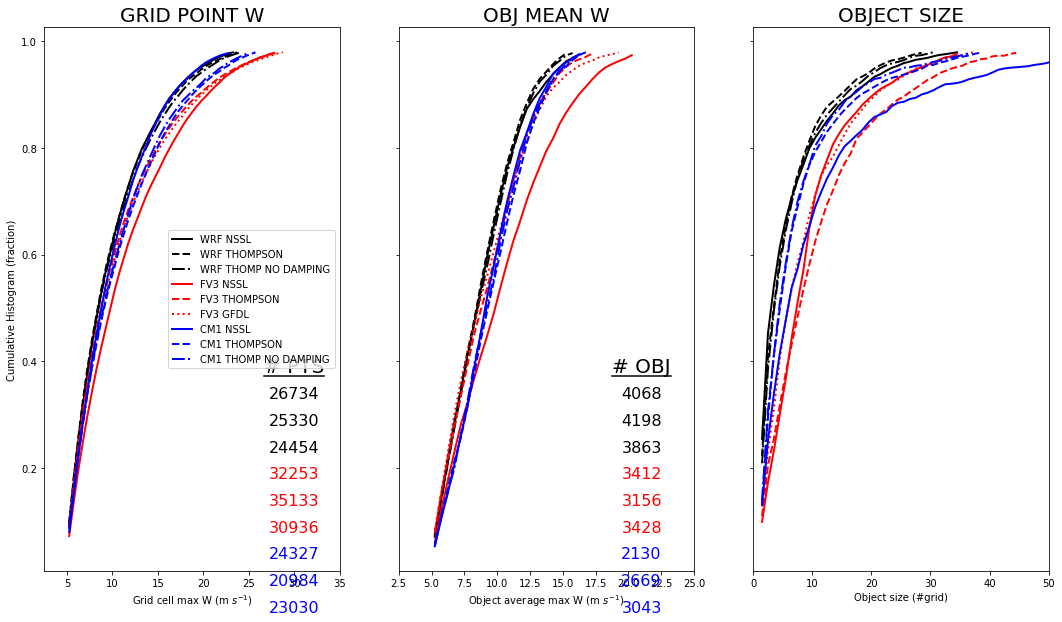

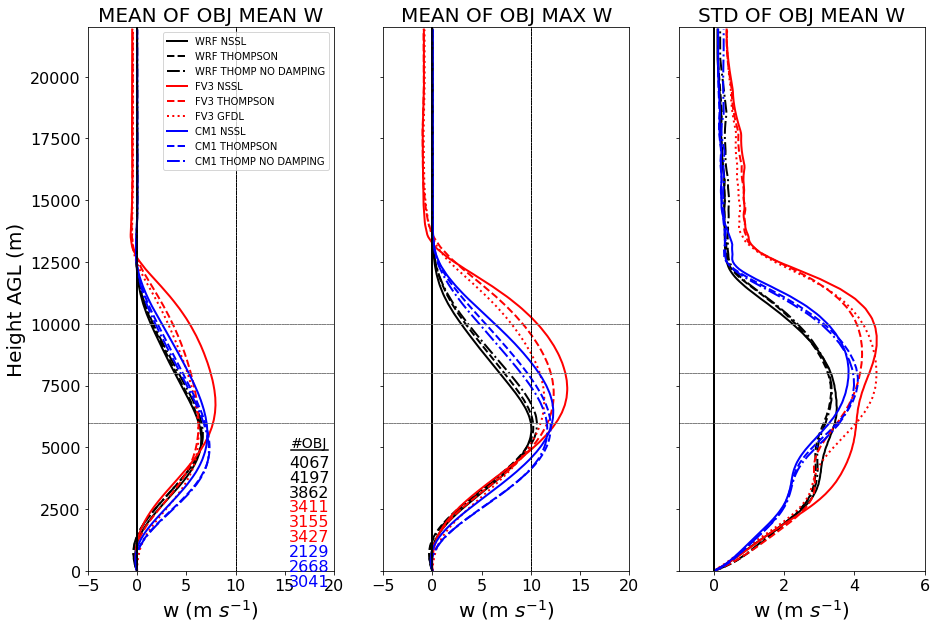

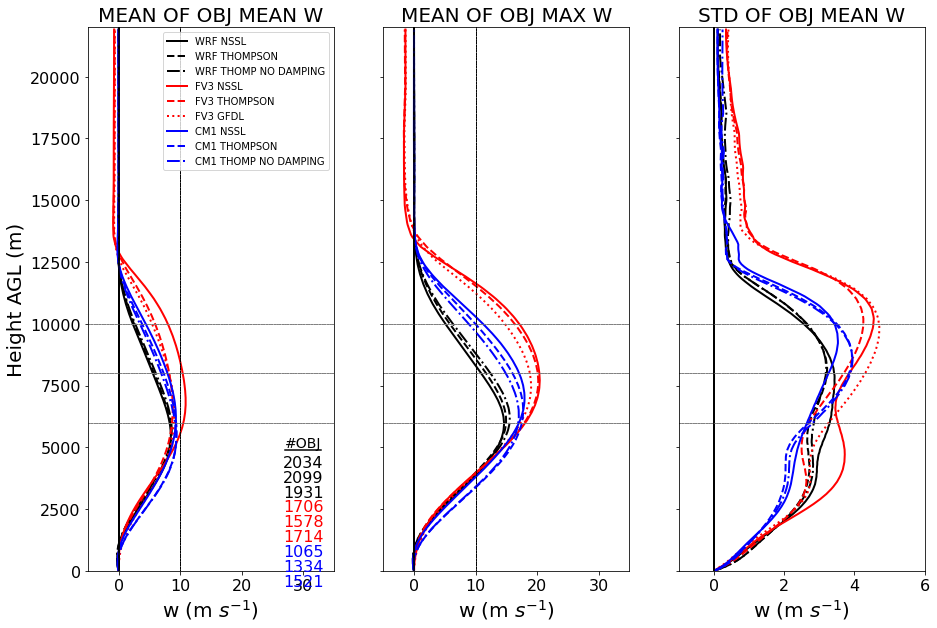

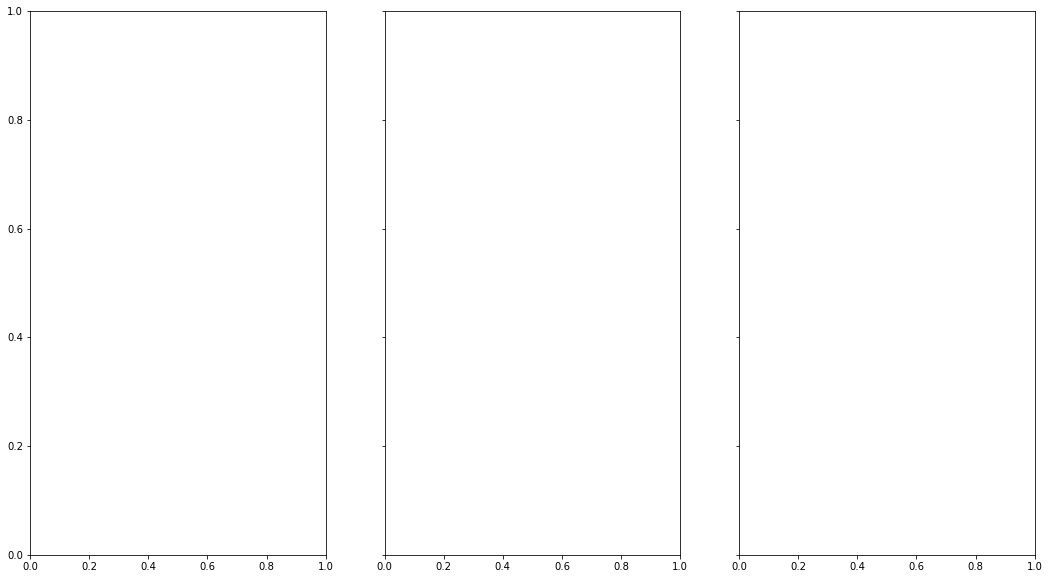

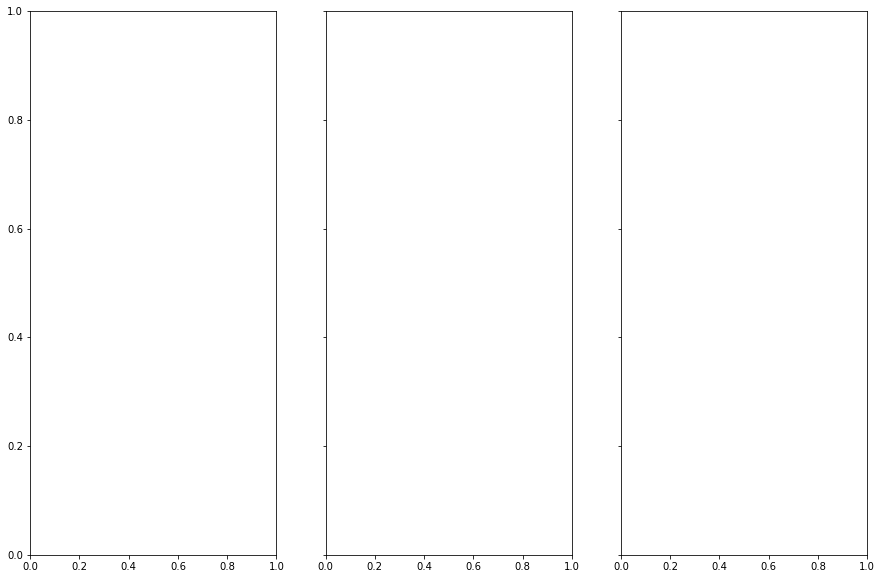

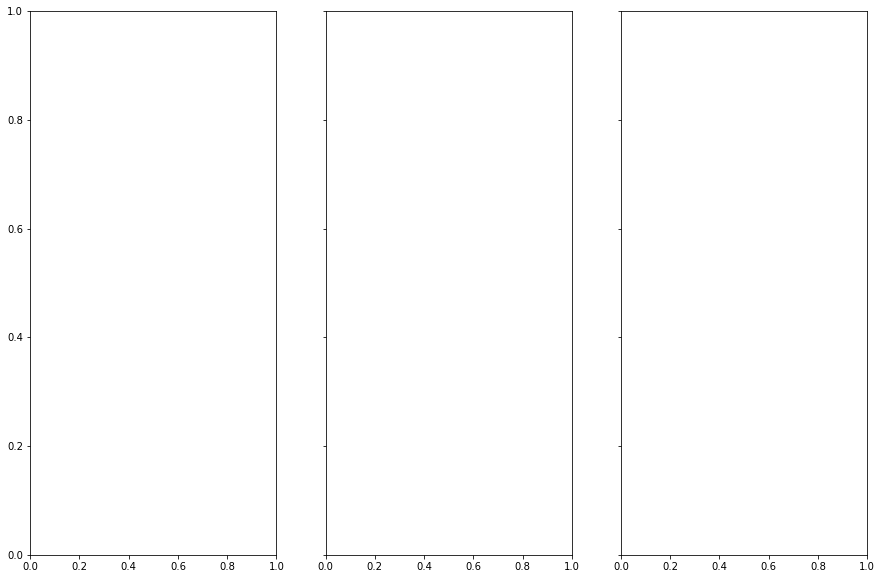

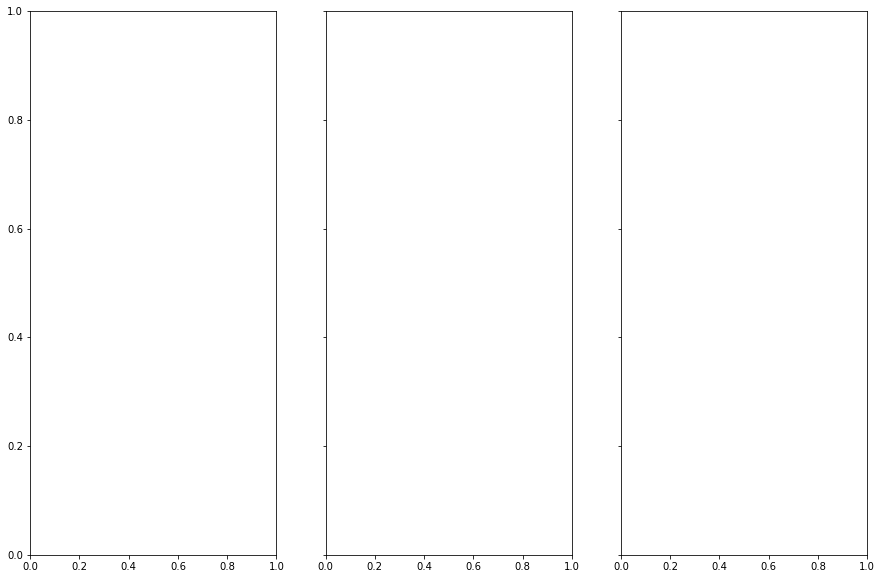

In [6]:
###### SET FILE NAMES AND CONSTANTS ######
ng = 1  # Number of groups to compare (e.g., WRF & FV3)
#group_names = ('WRF_km3_dt15','WRF_km4_dt15','WRF_km4_dt15_4.5km','FV3_dt20_hord5','FV3_dt20_hord6')  # Name of the groups to compare
#group_names = ('FV3_dt20_hord6_q11','FV3_dt20_hord6_q12','FV3_dt20_hord6_q13','FV3_dt20_hord6_q14','FV3_dt20_hord6_q15','FV3_dt20_hord6_q16')
#group_names = np.array([['WRF_C1000_new','WRF_C1500_new','WRF_C2000_new','WRF_C2500_new','WRF_C3000_new','WRF_C3500_new'],
#                        ['FV3_C1000_new','FV3_C1500_new','FV3_C2000_new','FV3_C2500_new','FV3_C3000_new','FV3_C3500_new'],
#                       ['CM1_C1000_new','CM1_C1500_new','CM1_C2000_new','CM1_C2500_new','CM1_C3000_new','CM1_C3500_new'],
#                       ['WRF_C1000_thomp_new','WRF_C1500_thomp_new','WRF_C2000_thomp_new','WRF_C2500_thomp_new','WRF_C3000_thomp_new','WRF_C3500_thomp_new'],
#                       ['FV3_C1000_thomp_new','FV3_C1500_thomp_new','FV3_C2000_thomp_new','FV3_C2500_thomp_new','FV3_C3000_thomp_new','FV3_C3500_thomp_new'],
#                       ['CM1_C1000_thomp_new','CM1_C1500_thomp_new','CM1_C2000_thomp_new','CM1_C2500_thomp_new','CM1_C3000_thomp_new','CM1_C3500_thomp_new'],
#                       ['FV3_C1000_gfdl_new','FV3_C1500_gfdl_new','FV3_C2000_gfdl_new','FV3_C2500_gfdl_new','FV3_C3000_gfdl_new','FV3_C3500_gfdl_new']])
#label_names = ([['WRF NSSL C1000','WRF NSSL C1500','WRF NSSL C2000','WRF NSSL C2500','WRF NSSL C3000','WRF NSSL C3500'],
#               ['FV3 NSSL C1000','FV3 NSSL C1500','FV3 NSSL C2000','FV3 NSSL C2500','FV3 NSSL C3000','FV3 NSSL C3500'],
#               ['CM1 NSSL C1000','CM1 NSSL C1500','CM1 NSSL C2000','CM1 NSSL C2500','CM1 NSSL C3000','CM1 NSSL C3500'],
#               ['WRF THOMPSON C1000','WRF THOMPSON C1500','WRF THOMPSON C2000','WRF THOMPSON C2500','WRF THOMPSON C3000','WRF THOMPSON C3500'],
#               ['FV3 THOMPSON C1000','FV3 THOMPSON C1500','FV3 THOMPSON C2000','FV3 THOMPSON C2500','FV3 THOMPSON C3000','FV3 THOMPSON C3500'],
#               ['CM1 THOMPSON C1000','CM1 THOMPSON C1500','CM1 THOMPSON C2000','CM1 THOMPSON C2500','CM1 THOMPSON C3000','CM1 THOMPSON C3500'],
#               ['FV3 GFDL C1000','FV3 GFDL C1500','FV3 GFDL C2000','FV3 GFDL C2500','FV3 GFDL C3000','FV3 GFDL C3500']] )
#set_names = ('WRF_NSSL','FV3_NSSL','CM1_NSSL','WRF_THOMP','FV3_THOMP','CM1_THOMP','FV3_GFDL')
#group_names = np.array([['WRF_C3500_new','WRF_C3500_thomp_new','FV3_C3500_new','FV3_C3500_thomp_new','FV3_C3500_gfdl_new','CM1_C3500_new','CM1_C3500_thomp_new'],
#                        ['WRF_C2000_new','WRF_C2000_thomp_new','FV3_C2000_new','FV3_C2000_thomp_new','FV3_C2000_gfdl_new','CM1_C2000_new','CM1_C2000_thomp_new']])

#label_names = ([['WRF NSSL C3500','WRF THOMPSON 3500','FV3 NSSL C3500','FV3 THOMPSON C3500','FV3 GFDL C3500','CM1 NSSL C3500','CM1 THOMPSON C3500'],
#                ['WRF NSSL C2000','WRF THOMPSON 2000','FV3 NSSL C2000','FV3 THOMPSON C2000','FV3 GFDL C2000','CM1 NSSL C2000','CM1 THOMPSON C2000']])
set_names = ['CGROUP','']
group_names = np.array([['WRF_CGROUP_nssl/shallow_12.5/*/','WRF_CGROUP_thomp/shallow_12.5/*/',
                         'WRF_CGROUP_thomp_nodamp/shallow_12.5/*/','FV3_CGROUP_nssl/shallow_12.5/*/',
                         'FV3_CGROUP_thomp/shallow_12.5/*/','FV3_CGROUP_gfdl/shallow_12.5/*/',
                         'CM1_CGROUP_nssl/shallow_12.5/*/','CM1_CGROUP_thomp/shallow_12.5/*/',
                         'CM1_CGROUP_thomp_nodamp/shallow_12.5/*/'],[]])
label_names = ([['WRF NSSL','WRF THOMPSON','WRF THOMP NO DAMPING',
                 'FV3 NSSL','FV3 THOMPSON','FV3 GFDL',
                 'CM1 NSSL','CM1 THOMPSON','CM1 THOMP NO DAMPING'],[]])
#group_names = ('WRF_qv11','WRF_qv12','WRF_qv13','WRF_qv14','WRF_qv15','WRF_qv16','CM1_q11','CM1_q12','CM1_q13','CM1_q14','CM1_q15','CM1_q16')
fstart = 15
fend = 360
fstep = 15
date = 'ideal'
#group_names = ('NORD3','')
top_dir = "/scratch/larissa.reames/ideal_updrafts"
shear = "shallow_12.5"
var_meso_id = 'w_dbz_ovl' # name of variable to use as cell identifier (w_max, uh, w_500)

min_size = 1
w_ths = [5.0,7.5]
cref_ths = [45.0,55.0]
nth = 2
track_th = 1
nf = 96

plot_ideal(top_dir,group_names,label_names,set_names,shear,w_ths[0],cref_ths[0],min_size,'_mp_wdist_cgroup',nf)

In [18]:
file = "/scratch/larissa.reames/ideal_updrafts/FV3_C2500_new/shallow_12.5/fv3_history.nc_0"
f = xr.open_dataset(file ,engine='netcdf4')
vap = np.array(f.spfh[0,::-1,:,:])
pres = np.array(f.pres[0,::-1,:,:])
temp = np.array(f.tmp[0,::-1,:,:])* (100000.0/pres)**(Rd/Cp)
z = np.array(-np.cumsum(f.delz[0,::-1,:,:],axis=0))
w = np.array(f.dzdt[0,::-1,:,:])
nz,ny,nx = np.shape(pres)
cref = np.nanmax(f.refl_10cm[0,::-1,:,:],axis=0)
cond = np.array((f.clwmr[0,::-1,:,:] + f.rwmr[0,::-1,:,:] + f.icmr[0,::-1,:,:] + f.snmr[0,::-1,:,:] + f.grle[0,::-1,:,:] + f.hail[0,::-1,:,:]))
pres = pres / (1 + vap * 0.607789855) #/ (1 - cond)
rho = 0.622*pres/(Rd*temp*(1+vap*0.622))
cond = cond * rho


[1.50146107e-07 5.63340109e-07 1.15653711e-06 1.90713854e-06
 2.83737995e-06 3.94699555e-06 5.23564177e-06 6.70294685e-06
 8.34852108e-06 1.01718842e-05 1.21729317e-05 1.43469597e-05
 1.66883401e-05 1.91958861e-05 2.18669920e-05 2.46830641e-05
 2.76005976e-05 3.06022121e-05 3.36670564e-05 3.68316323e-05
 4.00920944e-05 4.34412905e-05 4.69255210e-05 5.05292592e-05
 5.42687776e-05 5.81478962e-05 6.21758008e-05 6.63604151e-05
 7.07108120e-05 7.52363994e-05 7.99472109e-05 8.48538621e-05
 8.99675724e-05 9.53001945e-05 1.00864156e-04 1.06672509e-04
 1.12738941e-04 1.19077726e-04 1.25703766e-04 1.32632500e-04
 1.39880023e-04 1.47463128e-04 1.55399437e-04 1.63707897e-04
 1.72409404e-04 1.81528652e-04 1.91097788e-04 2.01155461e-04
 2.11805615e-04 2.22899398e-04 2.34698644e-04 2.47677992e-04
 2.62022397e-04 2.78487278e-04 2.98229628e-04 3.23376007e-04
 3.57972487e-04 4.11337212e-04 4.89055004e-04 6.60159625e-04]


suffix = suffix = suffix = suffix = suffix = suffix = suffix = suffix = suffix = suffix = suffix = suffix = suffix = suffix = suffix = suffix = suffix = suffix = suffix = suffix = suffix = suffix = suffix = suffix = 





















indir = /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c1000/
indir = /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c1000/
indir = /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c1000/indir = /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c1000/indir = /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c1000/indir = /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c1000/indir = /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c1000/indir = /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c1000/indir = /oldscratch/larissa.reames/WoF_FV3SAR/20

Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c1000//atmos_static.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c1000//atmos_static.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c1000//atmos_static.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c1000//atmos_static.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c1000//atmos_static.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c1000//atmos_static.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c1000//atmos_static.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c1000//atmos_static.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c1000//atmos_static.nc 
Opening /oldscratch/larissa.reames/Wo

Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c1500//atmos_static.nc 























Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c1500//atmos_static.nc 

Min max tk = 218.170349  299.846710
Min max tk = 218.073898  299.843079
Min max tk = 205.864594  299.851654
Min max tk = 202.332764  299.886108
Min max tk = 202.080322  300.039154
Min max tk = 202.769470  299.950531
Min max tk = 201.662216  299.917633
Min max tk = 201.763672  300.201996
Min max tk = 202.499405  299.902710
Min max tk = 204.758057  299.840179
Min max tk = 206.595490  299.860626
Min max tk = 199.067139  300.105652
Min max tk = 205.561432  299.897583
Min max tk = 202.229538  300.164948
Min max tk = 201.856674  299.898346
Min max tk = 208.945755  299.864532
Min max tk = 200.753510  299.941406
Min max tk = 200.567657  299.924255
Min max tk = 205.534637  299.921692
Min max tk = 203.866608  299.929443
Min max tk = 205.651932  299.886597
Min ma

Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c2000//fv3_history.nc 

Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c2000//fv3_history.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c2000//fv3_history.nc 

Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c2000//fv3_history.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c2000//fv3_history.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c2000//fv3_history.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c2000//fv3_history.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c2000//fv3_history.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c2000//fv3_history.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SA

Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c2500//grid_spec.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c2500//grid_spec.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c2500//grid_spec.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c2500//grid_spec.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c2500//grid_spec.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c2500//grid_spec.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c2500//grid_spec.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c2500//grid_spec.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c2500//grid_spec.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/

Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c3000//grid_spec.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c3000//grid_spec.nc 


Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c3000//grid_spec.nc 


Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c3000//grid_spec.nc 




















Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c3000//atmos_static.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c3000//atmos_static.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c3000//atmos_static.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c3000//atmos_static.nc 
Opening /oldscratch/larissa.reames/WoF_FV3SAR/20190520_periodic/201905202200/ENS01/c3000//atmos_static.nc 
Opening /oldscratch/laris

In [ ]:
vars_4d_mean = np.nanmean(vars_meso_4d,axis=(1,5)) #now run type, var,time, height
vars_4d_mean_plot = np.nanmean(vars_4d_mean[:,:,1:,:],axis=2)
linecolors=("black","xkcd:red","xkcd:grey")
linestyles=("-","-","--")
linewidths=(2,2,2)
th = 2
print(np.shape(vars_4d_mean_plot))


fig,ax = plt.subplots(1,2,sharey='row')
fig.set_size_inches(14,9)
#fig.subplots = plt.subplots_adjust(hspace=0.4, wspace=0.4)
#fig.suptitle(title, fontsize=24)

for i in np.arange(ng):
    print(i)
    ax[0].plot(vars_4d_mean_plot[i,1,th,:],z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i],label='{}'.format(group_names[i]))

#ax[0].set_xlim((-25.0,0.0))
ax[0].set_ylim((0,np.max(z_interp)))
ax[0].set_ylabel('Height AGL (m)')
#ax[0,0].set_xticks(np.arange(0,60,step=12))
ax[0].set_xlabel('T\' (K)')
ax[0].legend()

for i in np.arange(0,ng):
    ax[1].plot(vars_4d_mean_plot[i,0,th,:],z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i])

# ax[1].set_xlim((0.0,20.0))
ax[1].set_ylim((0,np.max(z_interp)))
#ax[0,0].set_xticks(np.arange(0,60,step=12))
ax[1].set_xlabel('w (m $s^{-1}$)')



<ipython-input-9-cabdfeb75145>:8: RuntimeWarning: Mean of empty slice
  avg_obj_size = np.nanmean(obj_sizes,axis=(1,4))*9.0


Text(0, 0.5, 'Mean uh ($m^2$ $s^{-2}$)')

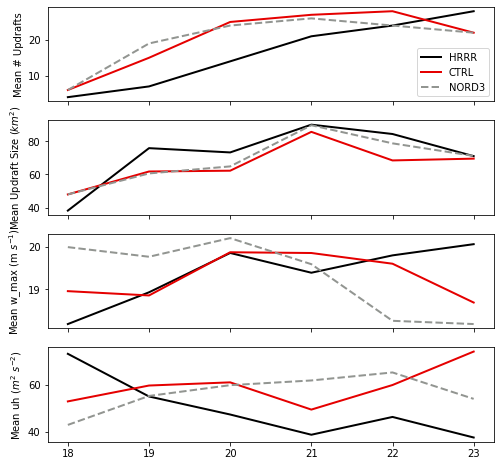

In [9]:
#obj_sizes[g,e,f,th,#]
#ng,ne,n_meso_4dvars,nf,nth,1000
linecolors=("black","xkcd:red","xkcd:grey")
linestyles=("-","-","--")
linewidths=(2,2,2)
th = 0
times = np.arange(18,24)
avg_obj_size = np.nanmean(obj_sizes,axis=(1,4))*9.0
counts = np.nanmean(np.count_nonzero(~np.isnan(obj_sizes), axis=4),axis=1)
vars_3d_mean = np.nanmean(vars_meso_3d,axis=(1,5))

counts_plot = counts[:,:,th]
avg_obj_size_plot = avg_obj_size[:,:,th]
vars_3d_mean_plot = vars_3d_mean[:,:,:,th]
fig,ax = plt.subplots(4,sharex='col')
fig.set_size_inches(8,8)
lines = []
#lines1 = ax[0].plot(time,counts[0,:],label=group_names[0],color=)
#lines = list(lines1)
for i in np.arange(ng):
    lines.append(ax[0].plot(times,counts_plot[i,:],label=group_names[i],color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i]))

#ax[0].set_xlim((0,48))
#ax[0].set_ylim((0,25))
ax[0].set_ylabel('Mean # Updrafts')
#ax[0].set_xticks(np.arange(0,60,step=12))
ax[0].legend()

for i in np.arange(ng):
    lines.append(ax[1].plot(times,avg_obj_size_plot[i,:],color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i]))

#ax[1].set_xlim((0,48))
#ax[1].set_ylim((0,140.0))
ax[1].set_ylabel('Mean Updraft Size ($km^{2}$)')
#ax[1].set_xticks(np.arange(0,60,step=12))

for i in np.arange(ng):
    lines.append(ax[2].plot(times,vars_3d_mean_plot[i,0,:],color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i]))

ax[2].set_ylabel('Mean %s (%s)'%(meso_3dvars_names[0],meso_3dvars_units[0]))

for i in np.arange(ng):
    lines.append(ax[3].plot(times,vars_3d_mean_plot[i,1,:],color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i]))

ax[3].set_ylabel('Mean %s (%s)'%(meso_3dvars_names[1],meso_3dvars_units[1]))

In [73]:
print(fs)

['/work/larissa.reames/2019071918/hrrr/region_201907191800_F04.nc', '/work/larissa.reames/2019071918/hrrr/region_201907191800_F05.nc', '/work/larissa.reames/2019071918/hrrr/region_201907191800_F06.nc', '/work/larissa.reames/2019071918/hrrr/region_201907191800_F07.nc', '/work/larissa.reames/2019071918/hrrr/region_201907191800_F08.nc', '/work/larissa.reames/2019071918/hrrr/region_201907191800_F09.nc']


(24, 200, 250, 2)
2
13
4
5
8
3
2
2
2
2
1
6
4
2
9
20
3
1
2
0.0


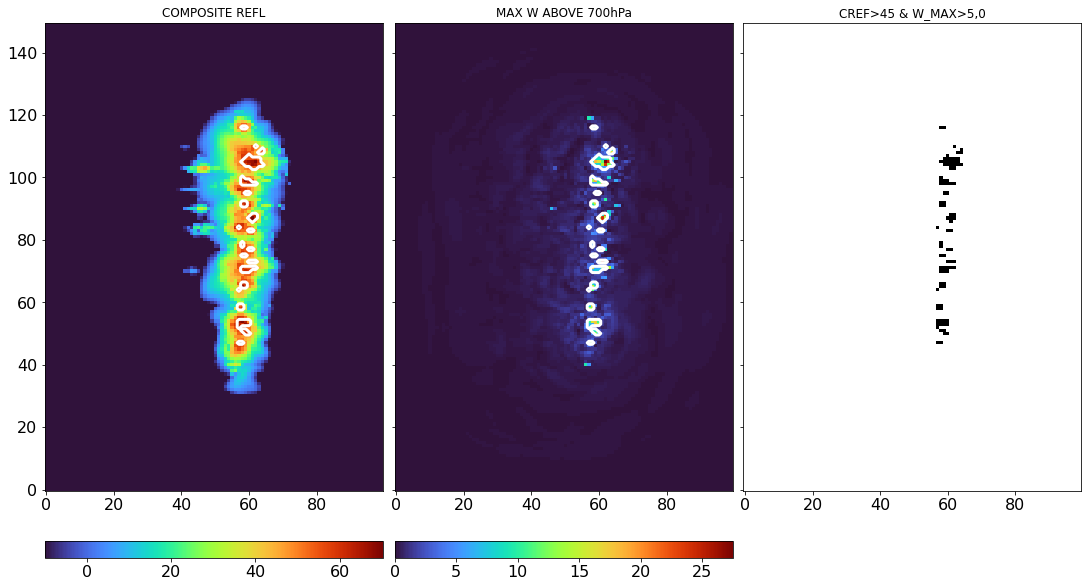

In [44]:
#obj_locs = np.full((ng,nf,200,200,2),np.nan)
##################################################################
########## Object center locations as a function of time #########
##################################################################
#lats = f.lats
#lons = f.lons
#lon_min = -90# np.amin(lons)
#lon_max = -80#np.amax(lons)
#lat_min = 35#np.amin(lats)
#lat_max = 40#np.amax(lats)
#ng,ne,nf,nth,1000
group = 0
ens = 0
th = 0

#proj = ccrs.LambertConformal(central_latitude = 30, 
#                             central_longitude = 265., 
#                             standard_parallels = (10,10))
        
fig,ax = plt.subplots(1,3,sharey='row',figsize=(15,8),constrained_layout=True)

#ax = plt.axes()

#ax.set_global()
#ax.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
#ax.add_feature(cfeature.BORDERS, linestyle=':')
#ax.add_feature(cfeature.STATES, linestyle=':')
#ax.set_extent([lon_min, lon_max, lat_min, lat_max])
#title = title_string(os.path.basename(file), klevel, 'W', cube[klevel].max(), cube[klevel].min())
    
#w_data = w_sign*np.ma.array(cube[klevel])

#wfinal = np.ma.masked_greater(np.ma.masked_less(w_data, w_limits[0]), w_limits[1])

#for t in np.arange(nf):
t = 11
f = xr.open_dataset(fs[t],engine='netcdf4')
w_full = f.W[0,:]
cref = np.nanmax(f.REFL_10CM[0,:],axis=0)
w = (w_full[0:-1,:]+w_full[1:,:])/2
del w_full

## Prepare data ##

# if we want to use max w as the cell identifier
w_abv700 = np.where(p<70000.0,w,np.nan)
w_max = np.nanmax(w_abv700,axis=0)

#Prepare centers
#nobjs = np.count_nonzero(~np.isnan(centers[group,ens,t,:,0]))
#centers_new = np.where(np.isnan(centers),-9999.9,centers)
obj_sizes_new = np.where(np.isnan(obj_sizes),-9999.9,obj_sizes)
#print(np.ma.masked_equal(obj_sizes_new[group,ens,t,:],-9999.9).compressed())
#lat_plot = []
#lon_plot = []
#for n in np.arange(nobjs):
#    x = np.ma.masked_equal(centers_new[group,t,:,0],-9999.9).compressed().astype(int)[n]
#    y = np.ma.masked_equal(centers_new[group,t,:,1],-9999.9).compressed().astype(int)[n]
#    lat_plot.append(lats[x,y])
#    lon_plot.append(lons[x,y])
#xlocs = centers[group,ens,t,th,np.argwhere(~np.isnan(centers[group,ens,t,th,:,0])),0].transpose().squeeze().astype(int)
#ylocs = centers[group,ens,t,th,np.argwhere(~np.isnan(centers[group,ens,t,th,:,1])),1].transpose().squeeze().astype(int)
#print(np.shape(xlocs))

#Prepare obj outlines
print(np.shape(obj_locs))
nobj = np.count_nonzero(~np.isnan(obj_locs[t,:,0,0]))
obj_points1 = np.full(np.shape(dbz),0.0)
obj_points2 = np.full(np.shape(dbz),0.0)
for l in np.arange(nobj):
    size = np.count_nonzero(~np.isnan(obj_locs[t,l,:,0]))
    print(size)
    obj_points1[obj_locs[t,l,:size,0].astype(int),obj_locs[t,l,:size,1].astype(int)] = 1.0
    for s in np.arange(size):
        x = obj_locs[t,l,s,0].astype(int)
        y = obj_locs[t,l,s,1].astype(int)
        obj_points2[x,y] = 1.0

print(np.sum(obj_points1-obj_points2))     
ovl = (dbz > 45.0) & (w_max > 5.0)
pc1 = ax[0].pcolormesh(np.arange(100), np.arange(150), dbz[50:200,0:100], cmap='turbo')#, transform=ccrs.PlateCarree())
ax[0].contour(np.arange(100),np.arange(150),obj_points1[50:200,0:100],levels=['0.5'],colors=['white'],linewidths=[3.0])#,transform=ccrs.PlateCarree())
pc2 = ax[1].pcolormesh(np.arange(100), np.arange(150), w_max[50:200,0:100], cmap='turbo')#, transform=ccrs.PlateCarree())
ax[1].contour(np.arange(100),np.arange(150),obj_points2[50:200,0:100],levels=['0.5'],colors=['white'],linewidths=[3.0])#,transform=ccrs.PlateCarree())
pc3 = ax[2].pcolormesh(np.arange(100), np.arange(150), ovl[50:200,0:100], cmap='Greys')#, transform=ccrs.PlateCarree())
#ax[2].contour(np.arange(100),np.arange(150),obj_points[50:200,0:100],levels=['0.5'],colors=['black'],linewidths=[3.0])#,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1,ax=ax[0],location='bottom')
cbar2 = fig.colorbar(pc2,ax=ax[1],location='bottom')
cbar1.ax.tick_params(labelsize=16) 
cbar2.ax.tick_params(labelsize=16) 
plt.setp(ax[0].get_xticklabels(), fontsize=16)
plt.setp(ax[1].get_xticklabels(), fontsize=16)
plt.setp(ax[2].get_xticklabels(), fontsize=16)
plt.setp(ax[0].get_yticklabels(), fontsize=16)
plt.setp(ax[1].get_yticklabels(), fontsize=16)
plt.setp(ax[2].get_yticklabels(), fontsize=16)
ax[0].set_title('COMPOSITE REFL')
ax[1].set_title('MAX W ABOVE 700hPa')
ax[2].set_title('CREF>45 & W_MAX>5,0')
#ax.set_title(title,fontsize=20)

plt.show()

fig.savefig('/scratch/larissa.reames/ideal_updrafts/obj_example_1.png',dpi=300)

In [5]:
f = xr.open_dataset('/scratch/larissa.reames/ideal_updrafts/FV3_C2500_nousecond/shallow_12.5/woffv3_d01_2019-05-20_22:30:00.nc' ,engine='netcdf4')
print(np.shape(f.W[0,:]))
print(np.shape(f.PHB[0,:]))

(61, 256, 256)
(61, 256, 256)
